In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import gamma
from scipy.stats import kstest, ks_2samp
from sklearn.preprocessing import LabelEncoder
import bnlearn as bn
import seaborn as sns

In [2]:
raw_data = pd.read_csv("kc_house_data.csv")
data1 = raw_data[['price', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot', 'sqft_lot15']].copy()
data2 = raw_data[['price', 'sqft_living', 'sqft_above', 'sqft_living15']].copy()

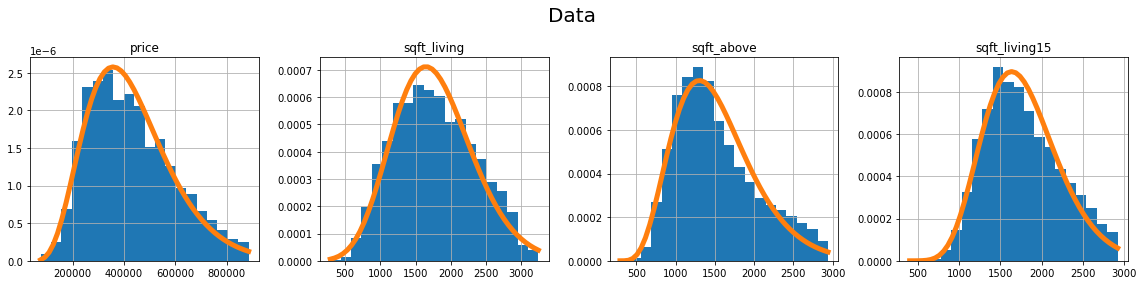

In [3]:
max_percent = 0.90
data2 = data2[(data2['price'] < data2['price'].quantile(max_percent)) &
              (data2['sqft_living'] < data2['sqft_living'].quantile(max_percent)) &
              (data2['sqft_above'] < data2['sqft_above'].quantile(max_percent)) &
              (data2['sqft_living15'] < data2['sqft_living15'].quantile(max_percent))]

params = dict()

fig = plt.figure(figsize=(16, 4))
fig.suptitle('Data', fontsize=20)

i = 1
for col_name in data2:
    params[col_name] = gamma.fit(data2[col_name])

    ax = plt.subplot(1, 4, i)
    i += 1

    data2[col_name].hist(density=True, bins=20)
    x = np.linspace(data2[col_name].min(), data2[col_name].max())
    plt.plot(x, gamma.pdf(x, *params[col_name]), linewidth=5)
    ax.set_title(col_name)

plt.tight_layout()
plt.show()

ks_test pvalue for price = 0.46
ks2_test pvalue for price = 0.66

ks_test pvalue for sqft_living = 0.95
ks2_test pvalue for sqft_living = 0.16

ks_test pvalue for sqft_above = 0.73
ks2_test pvalue for sqft_above = 0.14

ks_test pvalue for sqft_living15 = 0.56
ks2_test pvalue for sqft_living15 = 0.12



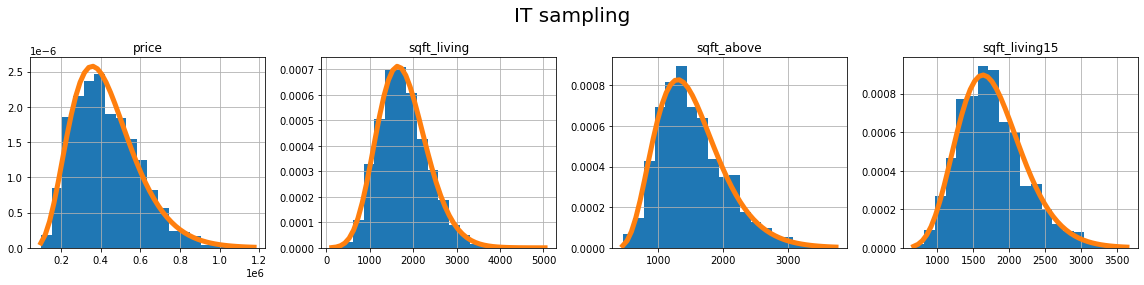

In [4]:
num_of_samples_it = 1000

fig = plt.figure(figsize=(16, 4))
fig.suptitle('IT sampling', fontsize=20)

i = 1
for col_name in data2:
    probas = np.random.uniform(size=num_of_samples_it)
    samples = pd.Series(gamma.ppf(probas, *params[col_name]))

    print(f'ks_test pvalue for {col_name} =', round(kstest(samples, 'gamma', args=params[col_name])[1], 2))
    print(f'ks2_test pvalue for {col_name} =', round(ks_2samp(samples, data2[col_name])[1], 2))
    print()

    ax = plt.subplot(1, 4, i)
    i += 1

    samples.hist(density=True, bins=20)
    x = np.linspace(samples.min(), samples.max())
    plt.plot(x, gamma.pdf(x, *params[col_name]), linewidth=5)
    ax.set_title(col_name)

plt.tight_layout()
plt.show()

ks_test pvalue for price = 0.01
ks2_test pvalue for price = 0.0

ks_test pvalue for sqft_living = 0.1
ks2_test pvalue for sqft_living = 0.0

ks_test pvalue for sqft_above = 0.03
ks2_test pvalue for sqft_above = 0.0

ks_test pvalue for sqft_living15 = 0.0
ks2_test pvalue for sqft_living15 = 0.0



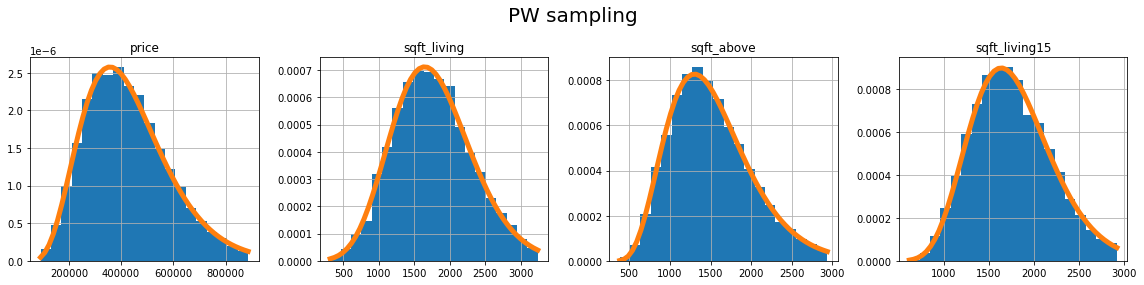

In [5]:
num_of_samples_pw = 10000
num_of_bars = 1000

fig = plt.figure(figsize=(16, 4))
fig.suptitle('PW sampling', fontsize=20)

i = 1
for col_name in data2:
    samp_min = data2[col_name].min()
    samp_max = data2[col_name].max()
    dx = (samp_max - samp_min) / num_of_bars

    bars = []

    cumul_prob = 0
    for j in range(num_of_bars):
        bar = dict()
        x_left = samp_min + j * dx
        x_right = x_left + dx
        prob = gamma.cdf(x_right, *params[col_name]) - gamma.cdf(x_left, *params[col_name])

        bar['left_side'] = x_left
        bar['right_side'] = x_right
        bar['prob_left'] = cumul_prob
        cumul_prob += prob
        bar['prob_right'] = cumul_prob
        bars.append(bar)

    probas = np.random.uniform(size=num_of_samples_pw)

    samples = []
    for prob in probas:
        for bar in bars:
            if bar['prob_left'] < prob <= bar['prob_right']:
                sample = bar['left_side'] + np.random.uniform() * (bar['right_side'] - bar['left_side'])
                samples.append(sample)
                break

    samples = pd.Series(samples)

    print(f'ks_test pvalue for {col_name} =', round(kstest(samples, 'gamma', args=params[col_name])[1], 2))
    print(f'ks2_test pvalue for {col_name} =', round(ks_2samp(samples, data2[col_name])[1], 2))
    print()

    ax = plt.subplot(1, 4, i)
    i += 1

    samples.hist(density=True, bins=20)
    x = np.linspace(samples.min(), samples.max())
    plt.plot(x, gamma.pdf(x, *params[col_name]), linewidth=5)
    ax.set_title(col_name)

plt.tight_layout()
plt.show()

In [6]:
cor_table_before_trans = data1.corr()
for col_name in cor_table_before_trans:
    cor_table_before_trans[col_name] = cor_table_before_trans[col_name].loc[cor_table_before_trans[col_name] > 0.5]    

n_categ = 100

for col_name in ['bathrooms', 'grade']:
    le = LabelEncoder()
    data1[col_name] = le.fit_transform(data1[col_name].values)


for col_name in ['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot', 'sqft_lot15']:
    new_col = []
    samp_min = data1[col_name].min()
    samp_max = data1[col_name].max()
    dx = (samp_max - samp_min) / n_categ

    for col_value in data1[col_name]:
        if col_value == samp_min:
            new_col.append(0)
            continue

        x = samp_min
        k = 0
        while x < col_value:
            x = samp_min + dx * (k + 1)
            k += 1

        new_col.append(k - 1)

    data1[col_name] = pd.Series(new_col)

    
cor_table_after_trans = data1.corr()
for col_name in cor_table_after_trans:
    cor_table_after_trans[col_name] = cor_table_after_trans[col_name].loc[cor_table_after_trans[col_name] > 0.5]

cor_table_before_trans
# cor_table_after_trans

,price,bathrooms,sqft_living,grade,sqft_above,sqft_living15,sqft_lot,sqft_lot15
price,1.000000,0.525138,0.702035,0.667434,0.605567,0.585379,NaN,NaN
bathrooms,0.525138,1.000000,0.754665,0.664983,0.685342,0.568634,NaN,NaN
sqft_living,0.702035,0.754665,1.000000,0.762704,0.876597,0.756420,NaN,NaN
grade,0.667434,0.664983,0.762704,1.000000,0.755923,0.713202,NaN,NaN
sqft_above,0.605567,0.685342,0.876597,0.755923,1.000000,0.731870,NaN,NaN
sqft_living15,0.585379,0.568634,0.756420,0.713202,0.731870,1.000000,NaN,NaN
sqft_lot,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.718557
sqft_lot15,NaN,NaN,NaN,NaN,NaN,NaN,0.718557,1.000000


[bnlearn] >Bayesian DAG created.
Model type: handmade
[bnlearn] >Plot based on BayesianModel


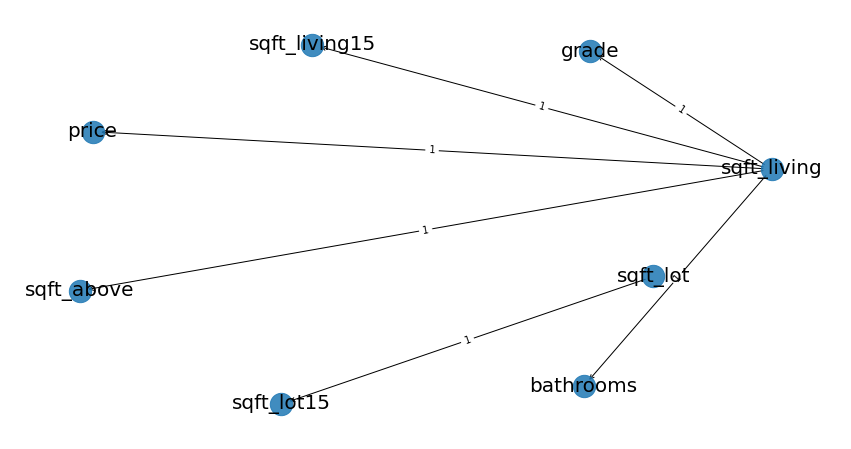

[BNLEARN][PARAMETER LEARNING] Computing parameters using [bayes]
CPD of sqft_living:
+-----------------+-------------+
| sqft_living(0)  | 0.00106804  |
+-----------------+-------------+
| sqft_living(1)  | 0.00173137  |
+-----------------+-------------+
| sqft_living(2)  | 0.0049596   |
+-----------------+-------------+
| sqft_living(3)  | 0.0196414   |
+-----------------+-------------+
| sqft_living(4)  | 0.0280879   |
+-----------------+-------------+
| sqft_living(5)  | 0.0426813   |
+-----------------+-------------+
| sqft_living(6)  | 0.0484302   |
+-----------------+-------------+
| sqft_living(7)  | 0.0648367   |
+-----------------+-------------+
| sqft_living(8)  | 0.0648367   |
+-----------------+-------------+
| sqft_living(9)  | 0.0651904   |
+-----------------+-------------+
| sqft_living(10) | 0.0650578   |
+-----------------+-------------+
| sqft_living(11) | 0.066694    |
+-----------------+-------------+
| sqft_living(12) | 0.0570535   |
+-----------------+------------

+----------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+--------------------

In [7]:
edges = [('sqft_living', 'sqft_living15'),
         ('sqft_living', 'sqft_above'),
         ('sqft_living', 'bathrooms'),
         ('sqft_living', 'grade'),
         ('sqft_living', 'price'),
         ('sqft_lot', 'sqft_lot15')]

handmade_model = bn.make_DAG(edges)
print('Model type: handmade')
G = bn.plot(handmade_model)
handmade_model_update = bn.parameter_learning.fit(handmade_model, data1)
print()
print()

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
Model type: hc_k2
[bnlearn] >Plot based on BayesianModel


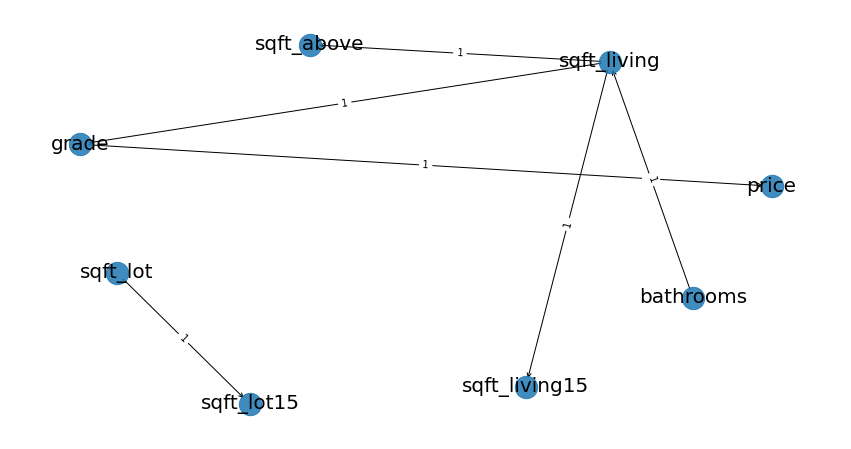

[BNLEARN][PARAMETER LEARNING] Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianModel.
CPD of bathrooms:
+---------------+------------+
| bathrooms(0)  | 0.0019163  |
+---------------+------------+
| bathrooms(1)  | 0.00165097 |
+---------------+------------+
| bathrooms(2)  | 0.00465809 |
+---------------+------------+
| bathrooms(3)  | 0.171819   |
+---------------+------------+
| bathrooms(4)  | 0.00187208 |
+---------------+------------+
| bathrooms(5)  | 0.0654196  |
+---------------+------------+
| bathrooms(6)  | 0.136264   |
+---------------+------------+
| bathrooms(7)  | 0.0868232  |
+---------------+------------+
| bathrooms(8)  | 0.0919972  |
+---------------+------------+
| bathrooms(9)  | 0.23939    |
+---------------+------------+
| bathrooms(10) | 0.0538776  |
+---------------+------------+
| bathrooms(11) | 0.0347735  |
+---------------+------------+
| bathrooms(12) | 0.027521   |
+---------------+------------+
| bathrooms(13) | 0.0338006  |

+-----------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+
| grade     | grade(0)             | grade(1)             | grade(2)             | grade(3)              | grade(4)              | grade(5)              | grade(6)               | grade(7)              | grade(8)              | grade(9)             | grade(10)            | grade(11)            |
+-----------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+
| price(0)  | 0.028056761485129263 | 0.027406797898601166 | 0.10118207909714438  | 0.14559258263907573   | 0.

Building tree: 100%|████████████████████████████████████████████████████████████████| 28/28.0 [00:00<00:00, 595.71it/s]

Model type: cl_k2
[bnlearn] >Plot based on BayesianModel


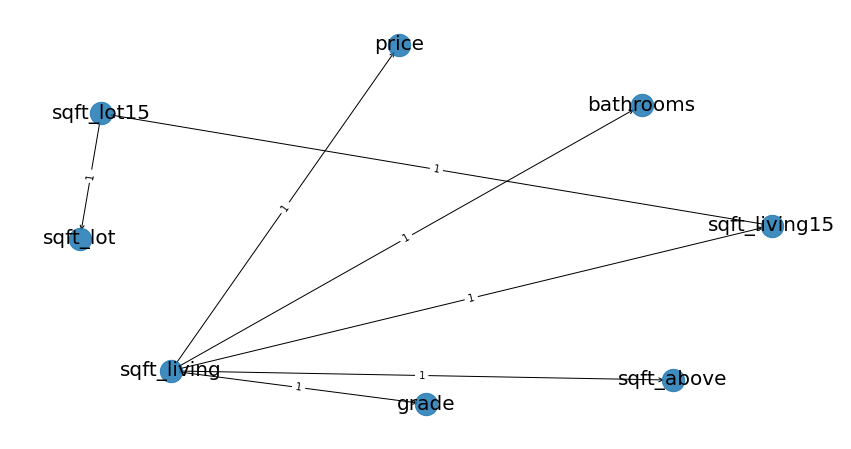

[BNLEARN][PARAMETER LEARNING] Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianModel.
CPD of sqft_living:
+-----------------+-------------+
| sqft_living(0)  | 0.00106804  |
+-----------------+-------------+
| sqft_living(1)  | 0.00173137  |
+-----------------+-------------+
| sqft_living(2)  | 0.0049596   |
+-----------------+-------------+
| sqft_living(3)  | 0.0196414   |
+-----------------+-------------+
| sqft_living(4)  | 0.0280879   |
+-----------------+-------------+
| sqft_living(5)  | 0.0426813   |
+-----------------+-------------+
| sqft_living(6)  | 0.0484302   |
+-----------------+-------------+
| sqft_living(7)  | 0.0648367   |
+-----------------+-------------+
| sqft_living(8)  | 0.0648367   |
+-----------------+-------------+
| sqft_living(9)  | 0.0651904   |
+-----------------+-------------+
| sqft_living(10) | 0.0650578   |
+-----------------+-------------+
| sqft_living(11) | 0.066694    |
+-----------------+-------------+
| sqft_living(1

+---------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------------+------------------------+-----------------------+-----------------------+------------------------+-----------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------

In [8]:
model_hc_k2 = bn.structure_learning.fit(data1, methodtype='hc', scoretype='k2')
model_hc_k2_update = bn.parameter_learning.fit(model_hc_k2, data1)

model_cl_k2 = bn.structure_learning.fit(data1, methodtype='cl', scoretype='k2', root_node='sqft_living')
model_cs_k2_update = bn.parameter_learning.fit(model_cl_k2, data1)

G = bn.plot(model_hc_k2)
# G = bn.plot(model_cl_k2)

In [9]:
df_handmade = bn.sampling(handmade_model_update, n=len(data2))
df_hc_k2 = bn.sampling(model_hc_k2_update, n=len(data2))
df_cs_k2 = bn.sampling(model_cs_k2_update, n=len(data2))

Generating for node: sqft_lot15:   0%|                                                           | 0/8 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 17571 samples..


Generating for node: sqft_lot15:   0%|                                                           | 0/8 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 17571 samples..


Generating for node: price:   0%|                                                                | 0/8 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 17571 samples..


Generating for node: sqft_above: 100%|███████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.49it/s]


ks_test pvalue for Handmade = 0.0
ks2_test pvalue for Handmade = 0.0

ks_test pvalue for Hill climb search = 0.0
ks2_test pvalue for Hill climb search = 0.0

ks_test pvalue for Chow-Liu method = 0.0
ks2_test pvalue for Chow-Liu method = 0.0



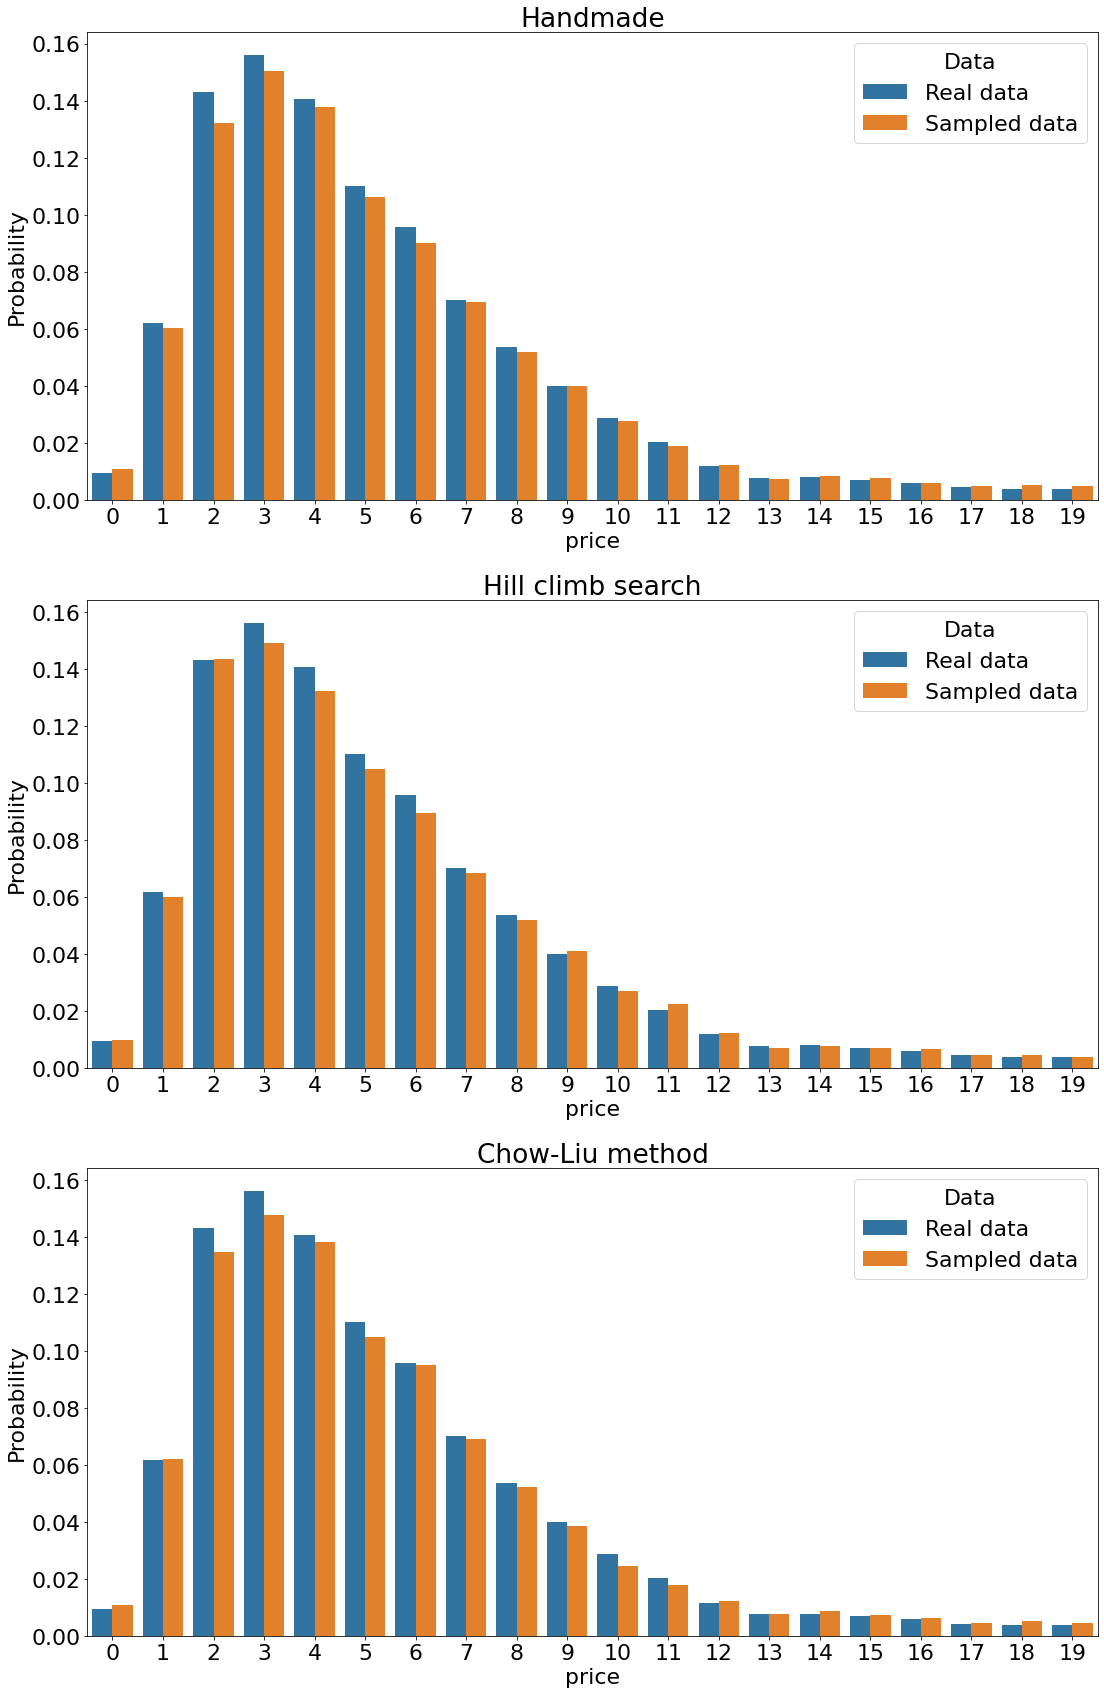

In [12]:
fig = plt.figure(figsize=(16, 24))

font = {'size': 22}
plt.rc('font', **font)

col_name = 'price'
cut_categ_namber = 20

i = 1
for model_name, df_model in [('Handmade', df_handmade), ('Hill climb search' ,df_hc_k2), ('Chow-Liu method' ,df_cs_k2)]:

    ax = plt.subplot(3, 1, i)
    i += 1

    df1 = pd.DataFrame()
    df1[col_name] = data1[col_name]
    df1['Data'] = 'Real data'
    df1['Probability'] = df1[col_name].apply(lambda x: (df1.groupby(col_name)[col_name].count()[x]) / data1.shape[0])

    df2 = pd.DataFrame()
    df2[col_name] = df_model[col_name]
    df2['Data'] = 'Sampled data'
    df2['Probability'] = df2[col_name].apply(lambda x: (df2.groupby(col_name)[col_name].count()[x]) / df_model.shape[0])
    final_df = pd.concat([df1, df2])
    final_df = final_df.loc[final_df[col_name] < cut_categ_namber]
    
    print(f'ks_test pvalue for {model_name} =', round(kstest(df_model[col_name], 'gamma', args=params[col_name])[1], 2))
    print(f'ks2_test pvalue for {model_name} =', round(ks_2samp(df_model[col_name], data2[col_name])[1], 2))
    print()

    sns.barplot(x=col_name, y="Probability", hue="Data", data=final_df)
    ax.set_title(model_name)

plt.tight_layout()
plt.show()